## Data Description and Analysis

In [1]:
!pip install sqlalchemy
!pip install pyhive
!pip install thrift
!pip install sasl
!pip install thrift-sasl 
!pip install psycopg2-binary
!pip install pandas plotnine

import sqlalchemy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 500)

import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()


The dataset contains relational set of files describing customers' orders over time. For each user, 4 to 100 orders are provided with the sequence of products purchased in each order. The data of the order's week and hour of the day as well as a relative measure of time between orders is provided.

**Files in the Dataset:** 

In [2]:

sparkConn = sqlalchemy.create_engine('hive://spark-thrift:10000/default')
pd.read_sql_query("use sample", con=sparkConn)
pd.read_sql_query("show tables", con=sparkConn)

,database,tableName,isTemporary
0,sample,avg_product_count_by_dow,False
1,sample,clean_orders,False
2,sample,daily_orders,False
3,sample,daily_orders_7_day_avg,False
4,sample,order_products,False
5,sample,order_products_union,False
6,sample,product_count,False
7,sample,stg_top_selling_products,False
8,sample,top_selling_aisles,False
9,sample,top_selling_departments,False


In [3]:

aisles = pd.read_sql_query("select * from source.aisles limit 1000000", con=sparkConn)
departments = pd.read_sql_query("select * from source.departments limit 1000000", con=sparkConn)
orders = pd.read_sql_query("select * from source.orders limit 1000000", con=sparkConn)
products = pd.read_sql_query("select * from source.products limit 1000000", con=sparkConn)

In [4]:

order_products_prior = pd.read_sql_query("select * from source.order_products__prior limit 1000000", con=sparkConn)
order_products_train = pd.read_sql_query("select * from source.order_products__train limit 1000000", con=sparkConn)


### aisles: 
This file contains different aisles and there are total 134 unique aisles.

In [5]:
aisles.head()

,aisle_id,aisle
0,NaN,aisle
1,1.0,prepared soups salads
2,2.0,specialty cheeses
3,3.0,energy granola bars
4,4.0,instant foods


In [6]:
aisles.tail()

,aisle_id,aisle
130,130.0,hot cereal pancake mixes
131,131.0,dry pasta
132,132.0,beauty
133,133.0,muscles joints pain relief
134,134.0,specialty wines champagnes


In [7]:
len(aisles.aisle.unique())

135

In [8]:
aisles.aisle.unique()

array(['aisle', 'prepared soups salads', 'specialty cheeses',
       'energy granola bars', 'instant foods',
       'marinades meat preparation', 'other', 'packaged meat',
       'bakery desserts', 'pasta sauce', 'kitchen supplies',
       'cold flu allergy', 'fresh pasta', 'prepared meals',
       'tofu meat alternatives', 'packaged seafood', 'fresh herbs',
       'baking ingredients', 'bulk dried fruits vegetables',
       'oils vinegars', 'oral hygiene', 'packaged cheese', 'hair care',
       'popcorn jerky', 'fresh fruits', 'soap', 'coffee', 'beers coolers',
       'red wines', 'honeys syrups nectars', 'latino foods',
       'refrigerated', 'packaged produce', 'kosher foods',
       'frozen meat seafood', 'poultry counter', 'butter',
       'ice cream ice', 'frozen meals', 'seafood counter',
       'dog food care', 'cat food care', 'frozen vegan vegetarian',
       'buns rolls', 'eye ear care', 'candy chocolate', 'mint gum',
       'vitamins supplements', 'breakfast bars pastries',

### departments: 
This file contains different departments and there are total 21 unique departments.

In [9]:
departments.head()

,department_id,department
0,NaN,department
1,1.0,frozen
2,2.0,other
3,3.0,bakery
4,4.0,produce


In [10]:
departments.tail()

,department_id,department
17,17.0,household
18,18.0,babies
19,19.0,snacks
20,20.0,deli
21,21.0,missing


In [11]:
len(departments.department.unique())

22

In [12]:
departments.department.unique()

array(['department', 'frozen', 'other', 'bakery', 'produce', 'alcohol',
       'international', 'beverages', 'pets', 'dry goods pasta', 'bulk',
       'personal care', 'meat seafood', 'pantry', 'breakfast',
       'canned goods', 'dairy eggs', 'household', 'babies', 'snacks',
       'deli', 'missing'], dtype=object)

### orders: 
This file contains all the orders made by different users. From below analysis, we can conclude following:

- There are total 3421083 orders made by total 206209 users.
- There are three sets of orders: Prior, Train and Test. The distributions of orders in Train and Test sets are similar whereas the distribution of orders in Prior set is different.
- The total orders per customer ranges from 0 to 100. 
- Based on the plot of 'Orders VS Day of Week' we can map 0 and 1 as Saturday and Sunday respectively based on the assumption that most of the people buy groceries on weekends.
- Majority of the orders are made during the day time.
- Customers order once in a week which is supported by peaks at 7, 14, 21 and 30 in 'Orders VS Days since prior order' graph.
- Based on the heatmap between 'Day of Week' and 'Hour of Day,' we can say that Saturday afternoons and Sunday mornings are prime time for orders.

In [13]:
orders.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,NaN,NaN,eval_set,NaN,NaN,NaN,NaN
1,2539329.0,1.0,prior,1.0,2.0,8.0,NaN
2,2398795.0,1.0,prior,2.0,3.0,7.0,15.0
3,473747.0,1.0,prior,3.0,3.0,12.0,21.0
4,2254736.0,1.0,prior,4.0,4.0,7.0,29.0
5,431534.0,1.0,prior,5.0,4.0,15.0,28.0
6,3367565.0,1.0,prior,6.0,2.0,7.0,19.0
7,550135.0,1.0,prior,7.0,1.0,9.0,20.0
8,3108588.0,1.0,prior,8.0,1.0,14.0,14.0
9,2295261.0,1.0,prior,9.0,1.0,16.0,0.0


In [14]:
orders.tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
999995,2162937.0,60078.0,prior,30.0,5.0,12.0,7.0
999996,1999510.0,60078.0,prior,31.0,2.0,16.0,11.0
999997,144910.0,60078.0,prior,32.0,3.0,10.0,8.0
999998,2885491.0,60078.0,prior,33.0,1.0,14.0,5.0
999999,1871936.0,60078.0,prior,34.0,4.0,16.0,3.0


In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                999999 non-null   float64
 1   user_id                 999999 non-null   float64
 2   eval_set                1000000 non-null  object 
 3   order_number            999999 non-null   float64
 4   order_dow               999999 non-null   float64
 5   order_hour_of_day       999999 non-null   float64
 6   days_since_prior_order  939921 non-null   float64
dtypes: float64(6), object(1)
memory usage: 53.4+ MB


In [16]:
len(orders.order_id.unique())

1000000

In [17]:
len(orders.user_id.unique())

60079

In [18]:
orders.eval_set.value_counts()

prior       939922
train        38174
test         21903
eval_set         1
Name: eval_set, dtype: int64

In [19]:
orders.order_number.describe().apply(lambda x: format(x, '.2f'))

count    999999.00
mean         17.19
std          17.72
min           1.00
25%           5.00
50%          11.00
75%          24.00
max         100.00
Name: order_number, dtype: object

In [20]:
order_number = orders.groupby('user_id')['order_number'].max()
order_number = order_number.value_counts()

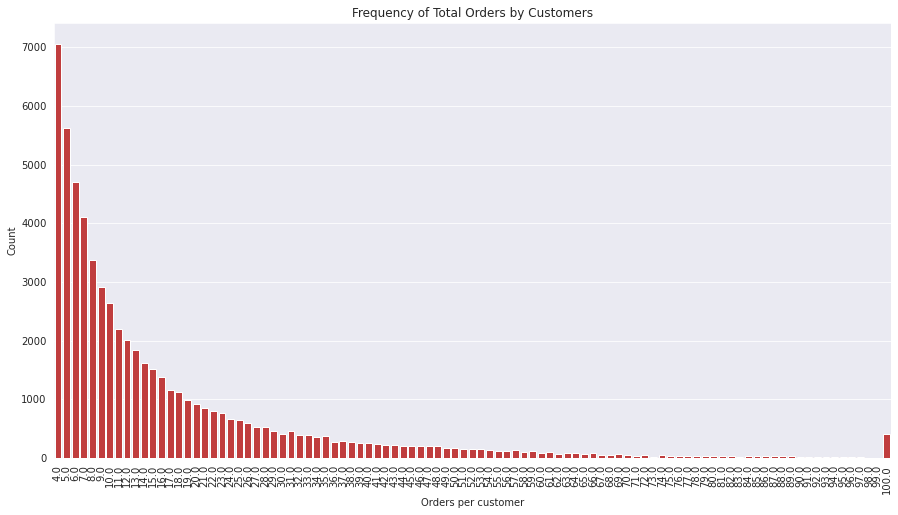

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x = order_number.index, y = order_number.values, color = color[3])
ax.set_xlabel('Orders per customer')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=90, labelsize=10)
ax.set_title('Frequency of Total Orders by Customers')
fig.savefig('./plot/Frequency of Total Orders by Customers.png')

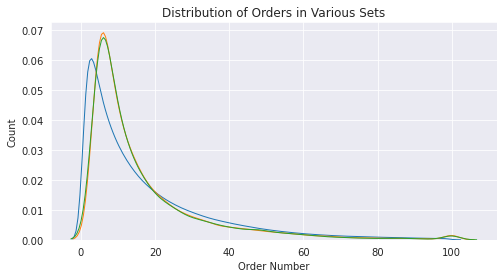

In [22]:
fig, ax = plt.subplots(figsize = (8,4))
ax = sns.kdeplot(orders.order_number[orders.eval_set == 'prior'], label = "Prior set", lw = 1)
ax = sns.kdeplot(orders.order_number[orders.eval_set == 'train'], label = "Train set", lw = 1)
ax = sns.kdeplot(orders.order_number[orders.eval_set == 'test'], label = "Test set", lw = 1)
ax.set_xlabel('Order Number')
ax.set_ylabel('Count')
ax.tick_params(axis = 'both', labelsize = 10)
ax.set_title('Distribution of Orders in Various Sets')
fig.savefig('./plot/Distribution of Orders in Various Sets.png')
plt.show()

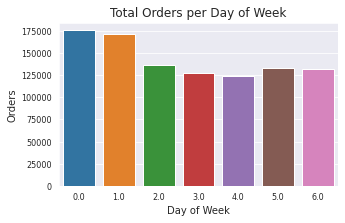

In [23]:
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.countplot(x=orders.order_dow)
ax.set_xlabel('Day of Week', size = 10)
ax.set_ylabel('Orders', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Total Orders per Day of Week')
fig.savefig('./plot/Total Orders per Day of Week.png')
plt.show()

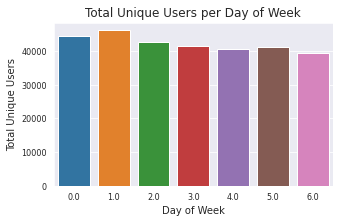

In [24]:
temp_df = orders.groupby('order_dow')['user_id'].nunique()

fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Day of Week', size = 10)
ax.set_ylabel('Total Unique Users', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Total Unique Users per Day of Week')
fig.savefig('./plot/Total Unique Users per Day of Week.png')
plt.show()

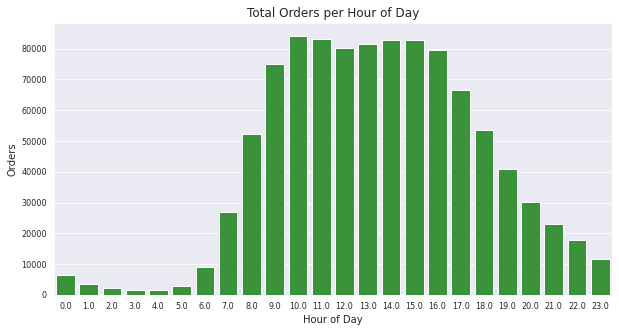

In [25]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.countplot(x=orders.order_hour_of_day, color = color[2])
ax.set_xlabel('Hour of Day', size = 10 )
ax.set_ylabel('Orders', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Total Orders per Hour of Day')
fig.savefig('./plot/Total Orders per Hour of Day.png')
plt.show()

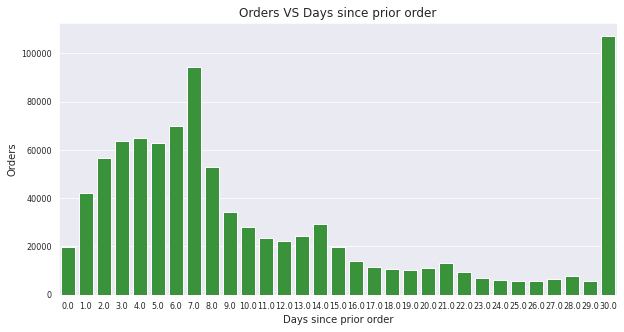

In [26]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.countplot(x=orders.days_since_prior_order, color = color[2])
ax.set_xlabel('Days since prior order', size = 10)
ax.set_ylabel('Orders', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Orders VS Days since prior order')
fig.savefig('./plot/Orders VS Days since prior order.png')
plt.show()

In [27]:
temp_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
temp_df = temp_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
temp_df.head()

order_hour_of_day,0.0,1.0,2.0,3.0,4.0,...,19.0,20.0,21.0,22.0,23.0
order_dow,,,,,,,,,,,
0.0,1146,681,417,304,222,...,6621,5311,4202,3298,2010
1.0,1049,528,328,234,253,...,6446,4659,3470,2571,1620
2.0,890,446,254,212,227,...,5874,4335,3162,2380,1547
3.0,859,428,274,181,231,...,5478,3951,3018,2433,1451
4.0,771,415,269,194,235,...,5618,4186,3196,2543,1637


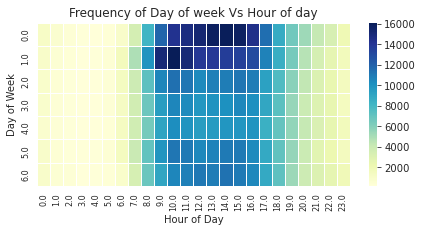

In [28]:
ax = plt.subplots(figsize=(7,3))
ax = sns.heatmap(temp_df, cmap="YlGnBu", linewidths=.5)
ax.set_title("Frequency of Day of week Vs Hour of day", size = 12)
ax.set_xlabel("Hour of Day", size = 10)
ax.set_ylabel("Day of Week", size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
fig = ax.get_figure()
fig.savefig("Frequency of Day of week Vs Hour of day.png")
plt.show()

### order_products_prior:

This file gives information about which products were ordered and in which order they were added in the cart. It also tells us that if the product was reordered or not. 

- In this file there is an information of total 3214874 orders through which total 49677 products were ordered. 
- From the 'Count VS Items in cart' plot, we can say that most of the people buy 1-15 items in an order and there were a maximum of 145 items in an order.
- The percentage of reorder items in this set is 58.97%.

In [29]:
order_products_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,NaN,NaN,NaN,NaN
1,2.0,33120.0,1.0,1.0
2,2.0,28985.0,2.0,1.0
3,2.0,9327.0,3.0,0.0
4,2.0,45918.0,4.0,1.0
5,2.0,30035.0,5.0,0.0
6,2.0,17794.0,6.0,1.0
7,2.0,40141.0,7.0,1.0
8,2.0,1819.0,8.0,1.0
9,2.0,43668.0,9.0,0.0


In [30]:
order_products_prior.tail()

,order_id,product_id,add_to_cart_order,reordered
999995,105629.0,3952.0,8.0,1.0
999996,105629.0,18670.0,9.0,1.0
999997,105629.0,7010.0,10.0,1.0
999998,105629.0,3142.0,11.0,1.0
999999,105629.0,28849.0,12.0,0.0


In [31]:
len(order_products_prior.order_id.unique())

99261

In [32]:
len(order_products_prior.product_id.unique())

35099

In [33]:
add_to_cart_order_prior = order_products_prior.groupby('order_id')['add_to_cart_order'].count()
add_to_cart_order_prior = add_to_cart_order_prior.value_counts()

In [34]:
add_to_cart_order_prior.head()

6    7055
5    7009
4    6846
7    6788
3    6319
Name: add_to_cart_order, dtype: int64

In [35]:
add_to_cart_order_prior.tail()

127    1
83     1
75     1
109    1
95     1
Name: add_to_cart_order, dtype: int64

In [36]:
add_to_cart_order_prior.index.max()

127

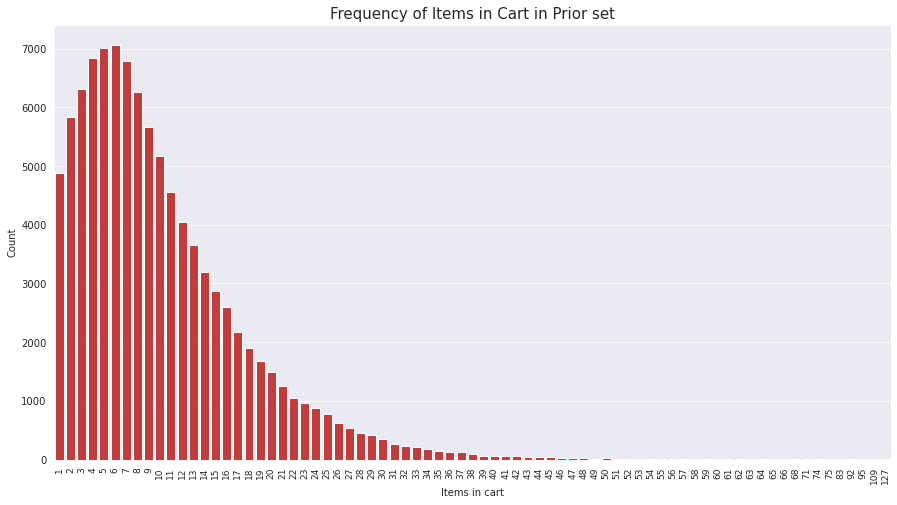

In [37]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = add_to_cart_order_prior.index, y = add_to_cart_order_prior.values, color = color[3])
ax.set_xlabel('Items in cart')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=90, labelsize = 9)
ax.set_title('Frequency of Items in Cart in Prior set', size = 15)
fig.savefig('./plot/Frequency of Items in Cart in Prior set.png')

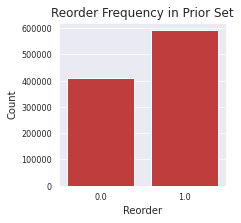

In [38]:
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.barplot(x = order_products_prior.reordered.value_counts().index, 
                y = order_products_prior.reordered.value_counts().values, color = color[3])
ax.set_xlabel('Reorder', size = 10)
ax.set_ylabel('Count', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.ticklabel_format(style='plain', axis='y')
ax.set_title('Reorder Frequency in Prior Set')
fig.savefig('./plot/Reorder Frequency in Prior Set')
plt.show()

In [39]:
print('Percentage of reorder in prior set:',
      format(order_products_prior[order_products_prior.reordered == 1].shape[0]*100/order_products_prior.shape[0], '.2f'))

Percentage of reorder in prior set: 59.03


### order_products_train:

This file gives information about which products were ordered and in which order they were added in the cart. It also tells us that if the product was reordered or not. 

- In this file there is an information of total 131209 orders through which total 39123 products were ordered. 
- From the 'Count VS Items in cart' plot, we can say that most of the people buy 1-15 items in an order and there were a maximum of 145 items in an order.
- The percentage of reorder items in this set is 59.86%.

In [40]:
order_products_train.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,NaN,NaN,NaN,NaN
1,1.0,49302.0,1.0,1.0
2,1.0,11109.0,2.0,1.0
3,1.0,10246.0,3.0,0.0
4,1.0,49683.0,4.0,0.0
5,1.0,43633.0,5.0,1.0
6,1.0,13176.0,6.0,0.0
7,1.0,47209.0,7.0,0.0
8,1.0,22035.0,8.0,1.0
9,36.0,39612.0,1.0,0.0


In [41]:
order_products_train.tail()

,order_id,product_id,add_to_cart_order,reordered
999995,2470459.0,35586.0,10.0,0.0
999996,2470459.0,9076.0,11.0,0.0
999997,2470483.0,28040.0,1.0,0.0
999998,2470483.0,17889.0,2.0,0.0
999999,2470483.0,39057.0,3.0,0.0


In [42]:
len(order_products_train.order_id.unique())

94955

In [43]:
len(order_products_train.product_id.unique())

36474

In [44]:
add_to_cart_order_train = order_products_prior.groupby('order_id')['add_to_cart_order'].count()
add_to_cart_order_train = add_to_cart_order_train.value_counts()

In [45]:
add_to_cart_order_train.head()

6    7055
5    7009
4    6846
7    6788
3    6319
Name: add_to_cart_order, dtype: int64

In [46]:
add_to_cart_order_train.tail()

127    1
83     1
75     1
109    1
95     1
Name: add_to_cart_order, dtype: int64

In [47]:
add_to_cart_order_train.index.max()

127

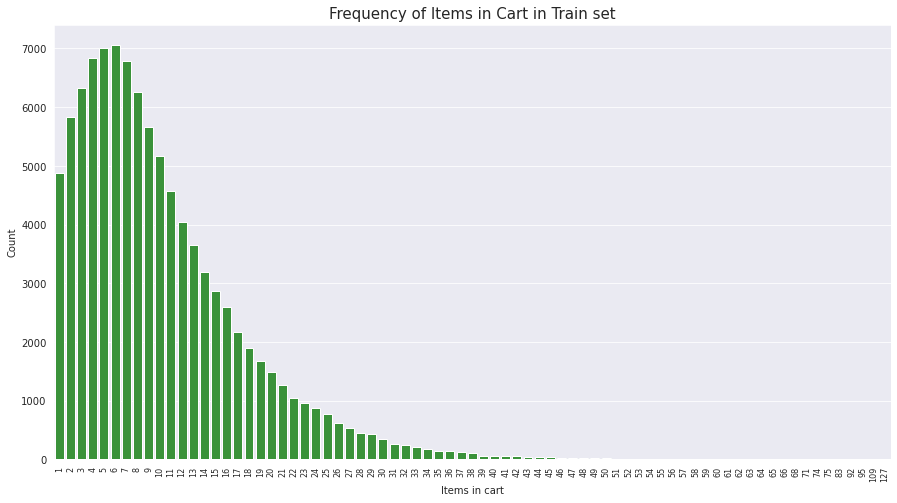

In [48]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = add_to_cart_order_train.index, y = add_to_cart_order_train.values, color = color[2])
ax.set_xlabel('Items in cart')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=90, labelsize = 8)
ax.set_title('Frequency of Items in Cart in Train set', size = 15)
fig.savefig('./plot/Frequency of Items in Cart in Train set.png')

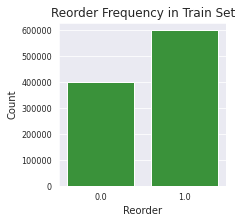

In [49]:
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.barplot(x = order_products_train.reordered.value_counts().index, 
                y = order_products_train.reordered.value_counts().values, color = color[2])
ax.set_xlabel('Reorder', size = 10)
ax.set_ylabel('Count', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Reorder Frequency in Train Set')
fig.savefig('./plot/Reorder Frequency in Train Set')
plt.show()

In [50]:
print('Percentage of reorder in train set:',
      format(order_products_train[order_products_train.reordered == 1].shape[0]*100/order_products_train.shape[0], '.2f'))

Percentage of reorder in train set: 59.83


### products:

This file contains the list of total 49688 products and their aisle as well as department. The number of products in different aisles and different departments are different.

In [51]:
products.head(10)

,product_id,product_name,aisle_id,department_id
0,NaN,product_name,NaN,NaN
1,1.0,Chocolate Sandwich Cookies,61.0,19.0
2,2.0,All-Seasons Salt,104.0,13.0
3,3.0,Robust Golden Unsweetened Oolong Tea,94.0,7.0
4,4.0,Smart Ones Classic Favorites Mini Rigatoni Wit...,38.0,1.0
5,5.0,Green Chile Anytime Sauce,5.0,13.0
6,6.0,Dry Nose Oil,11.0,11.0
7,7.0,Pure Coconut Water With Orange,98.0,7.0
8,8.0,Cut Russet Potatoes Steam N' Mash,116.0,1.0
9,9.0,Light Strawberry Blueberry Yogurt,120.0,16.0


In [52]:
products.tail()

,product_id,product_name,aisle_id,department_id
49684,49684.0,"""Vodka",NaN,NaN
49685,49685.0,En Croute Roast Hazelnut Cranberry,42.0,1.0
49686,49686.0,Artisan Baguette,112.0,3.0
49687,49687.0,Smartblend Healthy Metabolism Dry Cat Food,41.0,8.0
49688,49688.0,Fresh Foaming Cleanser,73.0,11.0


In [53]:
len(products.product_name.unique())

48616

In [54]:
len(products.aisle_id.unique())

135

In [55]:
len(products.department_id.unique())

130

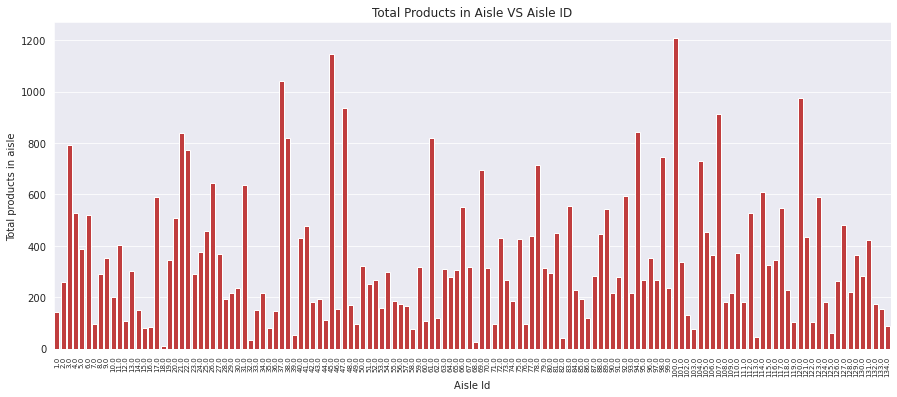

In [56]:
temp_df = products.groupby('aisle_id')['product_id'].count()

fig, ax = plt.subplots(figsize = (15,6))
ax = sns.barplot(x = temp_df.index, y = temp_df.values, color = color[3])
ax.set_xlabel('Aisle Id')
ax.set_ylabel('Total products in aisle')
ax.xaxis.set_tick_params(rotation=90, labelsize = 7)
ax.set_title('Total Products in Aisle VS Aisle ID', size = 12)
fig.savefig('./plot/Total Products in Aisle VS Aisle ID.png')

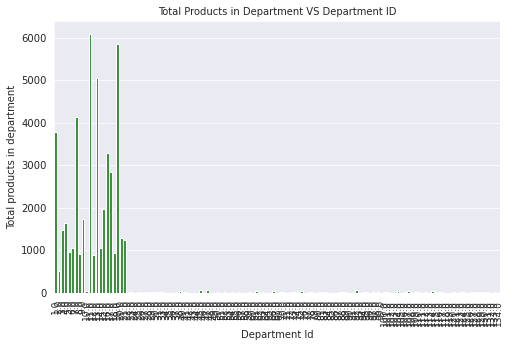

In [57]:
temp_df = products.groupby('department_id')['product_id'].count()

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = temp_df.index, y = temp_df.values, color = color[2])
ax.set_xlabel('Department Id')
ax.set_ylabel('Total products in department')
ax.xaxis.set_tick_params(rotation=90, labelsize = 9)
ax.set_title('Total Products in Department VS Department ID', size = 10)
fig.savefig('./plot/Total Products in Department VS Department ID.png')

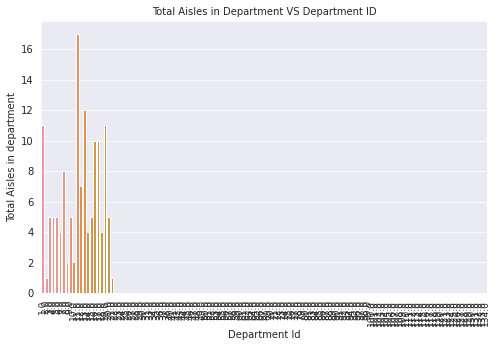

In [58]:
temp_df = products.groupby('department_id')['aisle_id'].nunique()

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Department Id')
ax.set_ylabel('Total Aisles in department')
ax.xaxis.set_tick_params(rotation=90, labelsize = 9)
ax.set_title('Total Aisles in Department VS Department ID', size = 10)
fig.savefig('./plot/Total Aisles in Department VS Department ID.png')

In [ ]:
sparkConn.connect().close()